# Generate permutations

In [ ]:
import itertools
import random

import numpy as np

from scipy.spatial.distance import hamming


# Build list of all possible permutations
permuts_list = list(itertools.permutations(range(9)))
permuts_array = np.array(permuts_list)
no_permuts = len(permuts_list)


# Take top x permutations which have max average hamming distance
permuts_to_take = 100#200
set_of_taken = set()
cnt_iterations = 0
while True:
    cnt_iterations += 1
    x = random.randint(1, no_permuts - 1)
    y = random.randint(1, no_permuts - 1)
    permut_1 = permuts_array[x]
    permut_2 = permuts_array[y]
    hd = hamming(permut_1, permut_2)

    if hd > 0.9 and (not x in set_of_taken) and (not y in set_of_taken):
        set_of_taken.add(x)
        set_of_taken.add(y)

        if len(set_of_taken) == permuts_to_take:
            break

    if cnt_iterations % 100 == 0:
        print ("Already performed count of iterations with pairs of jigsaw permutations", cnt_iterations)
        print ("Length of set of taken: ",len(set_of_taken))

print ("No of iterations it took to build top - {} permutations array = {}".format(permuts_to_take, cnt_iterations))
print ("No of permutations", len(set_of_taken))


# Build the array for selected permutation indices above
selected_permuts = []
for ind, perm_id in enumerate(set_of_taken):
    if ind < 10:
        print ("Sample permutation {}".format(ind))
        print (permuts_array[perm_id])
    selected_permuts.append(permuts_array[perm_id])

selected_permuts = np.array(selected_permuts)
np.save('selected_permuts.npy', selected_permuts)


Already performed count of iterations with pairs of jigsaw permutations 100
Length of set of taken:  66
No of iterations it took to build top - 100 permutations array = 148
No of permutations 100
Sample permutation 0
[7 0 3 6 1 4 2 8 5]
Sample permutation 1
[1 3 2 8 0 4 5 6 7]
Sample permutation 2
[2 0 3 1 6 5 7 4 8]
Sample permutation 3
[8 5 4 0 6 7 1 3 2]
Sample permutation 4
[4 2 7 8 3 6 5 0 1]
Sample permutation 5
[3 1 6 2 5 4 7 8 0]
Sample permutation 6
[7 2 6 5 4 1 3 8 0]
Sample permutation 7
[7 5 3 8 6 4 1 0 2]
Sample permutation 8
[6 1 5 0 4 8 2 3 7]
Sample permutation 9
[7 2 6 0 5 1 4 8 3]


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms


def_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

hflip_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

darkness_jitter_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=[0.5, 0.9]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

lightness_jitter_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=[1.1, 1.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

rotations_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

all_in_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


def crop_from_center(pil_image, new_h, new_w):

    width, height = pil_image.size  # Get dimensions

    left = (width - new_w) / 2
    top = (height - new_h) / 2
    right = (width + new_w) / 2
    bottom = (height + new_h) / 2

    # Crop the center of the image
    pil_image = pil_image.crop((left, top, right, bottom))

    return pil_image


def get_nine_crops(pil_image):
    """
    Get nine crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/3)

    r_vals = [0, diff, 2 * diff]
    c_vals = [0, diff, 2 * diff]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches


def split_train_into_train_val(train_file_ids, train_file_paths, train_labels, test_size=0.1):
    """
    Split train_file_paths and train_labels to train_file_paths, val_file_paths and
    train_labels, val_labels
    """

    # Create a mapping between image_id and file_path
    image_id_name_map = dict(zip(train_file_ids, train_file_paths))

    # Get validation files and validation labels separate
    train_file_ids, val_file_ids, train_labels, val_labels = train_test_split(
        train_file_ids, train_labels, test_size=test_size, random_state=5, shuffle=True
    )
    train_file_paths = [image_id_name_map[image_id] for image_id in train_file_ids]
    val_file_paths = [image_id_name_map[image_id] for image_id in val_file_ids]

    print ("Length of train files list", len(train_file_paths))
    print ("Length of train labels", len(train_labels))
    print ("Length of val files list", len(val_file_paths))
    print ("Length of val labels", len(val_labels))

    return train_file_ids, val_file_ids, train_file_paths, val_file_paths, train_labels, val_labels

def get_paths(data_dir):
    file_paths_to_return = []

    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".jpg"):
                file_paths_to_return.append(data_dir+'/'+file)

    return file_paths_to_return

def get_train_test_file_paths_n_labels():
    """
    Get array train_file_paths, train_labels, test_file_paths and test_labels
    """

    # Data loading and data generators set up
    #par_data_dir = 'train'
    images_data_dir = 'train'
    train_test_split_file = 'train_test_split.txt'
    images_file = 'images.txt'
    labels_file = 'image_class_labels.txt'

    # Read the images_file which stores image-id and image-name mapping
    image_file_id_df = pd.read_csv(images_file, sep=' ', header=None)
    image_file_id_mat = image_file_id_df.values
    image_id_name_map = dict(zip(image_file_id_mat[:, 0], image_file_id_mat[:, 1]))

    # Read the train_test_split file which stores image-id and train-test split mapping
    image_id_train_test_split_df = pd.read_csv(train_test_split_file, sep=' ', header=None)
    image_id_train_test_split_mat = image_id_train_test_split_df.values
    image_id_train_test_split_map = dict(zip(image_id_train_test_split_mat[:, 0],
                                             image_id_train_test_split_mat[:, 1]))

    # Read the image class labels file
    image_id_label_df = pd.read_csv(labels_file, sep=' ', header=None)
    image_id_label_mat = image_id_label_df.values
    image_id_label_map = dict(zip(image_id_label_mat[:, 0], image_id_label_mat[:, 1]))

    # Put together train_files train_labels test_files and test_labels lists
    train_image_ids, test_image_ids = [], []
    train_file_paths, test_file_paths = [], []
    train_labels, test_labels = [], []
    for file_id in image_id_name_map.keys():
        file_name = image_id_name_map[file_id]
        is_train = image_id_train_test_split_map[file_id]
        label = image_id_label_map[file_id] - 1  # To ensure labels start from 0

        if is_train:
            train_image_ids.append(file_id)
            train_file_paths.append(os.path.join(images_data_dir, file_name))
            train_labels.append(label)
        else:
            test_image_ids.append(file_id)
            test_file_paths.append(os.path.join(images_data_dir, file_name))
            test_labels.append(label)

    print ("Length of train files list", len(train_file_paths))
    print ("Length of train labels list", len(train_labels))
    print ("Length of test files list", len(test_file_paths))
    print ("Length of test labels list", len(test_labels))

    return train_image_ids, test_image_ids, train_file_paths, test_file_paths, train_labels, test_labels



# Generate Jigsaw from permutations

In [3]:
import json
import numpy as np
import random

import torch
from PIL import Image
from torch.utils.data import Dataset

#from dataset_helpers import crop_from_center, get_nine_crops


class GetDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, labels, transform=None):
        'Initialization'
        self.imgs = [(img_path, label) for img_path, label in zip(file_paths, labels)]
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        label = self.labels[index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            label = self.labels[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        tr_image = self.transform(pil_image)

        return tr_image, label


class GetJigsawPuzzleDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, avail_permuts_file_path, range_permut_indices=None, transform=None):
        'Initialization'
        self.file_paths = file_paths
        self.transform = transform
        self.permuts_avail = np.load(avail_permuts_file_path)
        self.range_permut_indices = range_permut_indices

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        pil_image = pil_image.resize((256, 256))


        pil_image = crop_from_center(pil_image, 225, 225)

        # Get nine crops for the image
        nine_crops = get_nine_crops(pil_image)

        # Permut the 9 patches obtained from the image
        if self.range_permut_indices:
            permut_ind = random.randint(self.range_permut_indices[0], self.range_permut_indices[1])
        else:
            permut_ind = random.randint(0, len(self.permuts_avail) - 1)

        permutation_config = self.permuts_avail[permut_ind]

        permuted_patches_arr = [None] * 9
        for crop_new_pos, crop in zip(permutation_config, nine_crops):
            permuted_patches_arr[crop_new_pos] = crop


        # Apply data transforms
        tensor_patches = torch.zeros(9, 3, 64, 64)
        for ind, jigsaw_patch in enumerate(permuted_patches_arr):
            jigsaw_patch_tr = self.transform(jigsaw_patch)
            tensor_patches[ind] = jigsaw_patch_tr

        return tensor_patches, permut_ind


In [4]:
import json
import numpy as np
import random

import torch
from PIL import Image
from torch.utils.data import Dataset
class JigsawPuzzleDatasetWithRotation(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.grid_size = 3  # 3x3 puzzle
        self.num_patches = self.grid_size ** 2
        self.rotation_list = random.choices([0, 1, 2, 3], k=len(image_paths * (self.grid_size ** 2)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize((256,256))
        w, h = img.size
        patch_w, patch_h = w // self.grid_size, h // self.grid_size



        # Split image into patches
        patches = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch = img.crop((j*patch_w, i*patch_h, (j+1)*patch_w, (i+1)*patch_h))
                patches.append(patch)


        # Create permutation
        perm = list(range(self.num_patches))
        random.shuffle(perm)
        shuffled_patches = [patches[i] for i in perm]


        #Shuffled
        plt.subplot(3,4,3)
        plt.title("Shuffled")
        patch_tensor = torch.tensor(np.array(shuffled_patches))
        rows = (torch.cat(tuple(patch_tensor[0:3]), dim=1), torch.cat(tuple(patch_tensor[3:6]), dim=1), torch.cat(tuple(patch_tensor[6:9]), dim=1))
        patch_tensor = torch.cat(rows, dim=0)
        plt.imshow(patch_tensor)

        # Transform each
        if self.transform:
            shuffled_patches = [self.transform(p) for p in shuffled_patches]

        rand_crop = transforms.Compose([
            transforms.RandomCrop((64, 64)),
            transforms.ToTensor(),
        ])


        color_jitter = transforms.Compose([
            transforms.ColorJitter(brightness=[0.5, 1.5]),
        ])


        # Apply random rotations to each patch
        rotations = []
        rotated_patches = [] # Shape patches, height, width, channels
        for patch_idx, patch in enumerate(shuffled_patches):
            rot = self.rotation_list[idx + patch_idx]
            rotations.append(rot)  # store as 0,1,2,3
            patch = patch.rot90(rot, dims=(1, 2))
            rotated_patches.append(patch)



        # Stack patches into tensor: (9, C, H, W)
        patch_tensor = torch.stack(rotated_patches, dim=0)
        perm_tensor = torch.tensor(perm, dtype=torch.long)
        rot_tensor = torch.tensor(rotations, dtype=torch.long)

        # Return patches, permutation, and rotation
        return patch_tensor, perm_tensor, rot_tensor


In [5]:
import json
import numpy as np
import random

import torch
from PIL import Image
from torch.utils.data import Dataset
class JigsawPuzzleDatasetWithRotationWithPrints(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.grid_size = 3  # 3x3 puzzle
        self.num_patches = self.grid_size ** 2
        self.rotation_list = random.choices([0, 1, 2, 3], k=len(image_paths * (self.grid_size ** 2)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')


        #DEBUG
        plt.subplot(3,4,1)
        plt.title("Original")
        plt.imshow(img)

        img = img.resize((256,256))

        #DEBUG
        plt.subplot(3,4,1)
        plt.title("Resized")
        plt.imshow(img)


        w, h = img.size
        patch_w, patch_h = w // self.grid_size, h // self.grid_size

        # Split image into patches
        patches = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch = img.crop((j*patch_w, i*patch_h, (j+1)*patch_w, (i+1)*patch_h))
                patches.append(patch)

        #DEBUG
        plt.subplot(3,4,2)
        plt.title("Patches")
        patch_tensor = torch.tensor(np.array(patches))
        patch_tensor = patch_tensor.permute(0, 3, 1, 2)
        patch_tensor = torch.nn.functional.pad(patch_tensor, (5, 5, 5, 5))
        patch_tensor = patch_tensor.permute(0, 2, 3, 1)
        rows = (torch.cat(tuple(patch_tensor[0:3]), dim=1), torch.cat(tuple(patch_tensor[3:6]), dim=1), torch.cat(tuple(patch_tensor[6:9]), dim=1))
        patch_tensor = torch.cat(rows, dim=0)
        plt.imshow(patch_tensor)


        # Create permutation
        perm = list(range(self.num_patches))
        random.shuffle(perm)
        shuffled_patches = [patches[i] for i in perm]


        #Shuffled
        plt.subplot(3,4,3)
        plt.title("Shuffled")
        patch_tensor = torch.tensor(np.array(shuffled_patches))
        rows = (torch.cat(tuple(patch_tensor[0:3]), dim=1), torch.cat(tuple(patch_tensor[3:6]), dim=1), torch.cat(tuple(patch_tensor[6:9]), dim=1))
        patch_tensor = torch.cat(rows, dim=0)
        plt.imshow(patch_tensor)

        # Transform each
        if self.transform:
            shuffled_patches = [self.transform(p) for p in shuffled_patches]


        #DEBUG
        plt.subplot(3,4,5)
        plt.title("Transformed")
        patch_tensor = torch.tensor(np.array(shuffled_patches))
        rows = (torch.cat(tuple(patch_tensor[0:3]), dim=2), torch.cat(tuple(patch_tensor[3:6]), dim=2), torch.cat(tuple(patch_tensor[6:9]), dim=2))
        patch_tensor = torch.cat(rows, dim=1)
        patch_tensor = patch_tensor.permute(1, 2, 0)
        plt.imshow(patch_tensor)

        # Apply random rotations to each patch
        rotations = []
        rotated_patches = [] # Shape patches, height, width, channels
        for patch_idx, patch in enumerate(shuffled_patches):
            rot = self.rotation_list[idx + patch_idx]
            rotations.append(rot)  # store as 0,1,2,3
            patch = patch.rot90(rot, dims=(1, 2))
            rotated_patches.append(patch)


        #DEBUG
        plt.subplot(3,4,6)
        plt.title("Rotated")
        rows = (torch.cat(tuple(rotated_patches[0:3]), dim=2), torch.cat(tuple(rotated_patches[3:6]), dim=2), torch.cat(tuple(rotated_patches[6:9]), dim=2))
        rot_patch_im = torch.cat(rows, dim=1)
        rot_patch_im = rot_patch_im.permute((1, 2, 0))
        plt.imshow(rot_patch_im)

        # Stack patches into tensor: (9, C, H, W)
        patch_tensor = torch.stack(rotated_patches, dim=0)
        perm_tensor = torch.tensor(perm, dtype=torch.long)
        rot_tensor = torch.tensor(rotations, dtype=torch.long)

        # Return patches, permutation, and rotation
        return patch_tensor, perm_tensor, rot_tensor


[tensor([[[[[0.1412, 0.1412, 0.1412,  ..., 0.0078, 0.0000, 0.0118],
           [0.1608, 0.1686, 0.1725,  ..., 0.0039, 0.0039, 0.0157],
           [0.1529, 0.1490, 0.1647,  ..., 0.0118, 0.0196, 0.0392],
           ...,
           [0.4902, 0.5059, 0.5137,  ..., 0.6196, 0.6196, 0.5529],
           [0.5059, 0.4863, 0.4824,  ..., 0.6157, 0.6118, 0.5608],
           [0.4510, 0.4784, 0.4980,  ..., 0.5843, 0.5804, 0.5569]],

          [[0.3373, 0.3373, 0.3137,  ..., 0.0353, 0.0431, 0.0627],
           [0.3412, 0.3412, 0.3294,  ..., 0.0784, 0.0902, 0.1059],
           [0.3412, 0.3373, 0.3373,  ..., 0.1255, 0.1412, 0.1647],
           ...,
           [0.5725, 0.5804, 0.5882,  ..., 0.6784, 0.6627, 0.6078],
           [0.5608, 0.5451, 0.5412,  ..., 0.6745, 0.6471, 0.6078],
           [0.5176, 0.5412, 0.5608,  ..., 0.6549, 0.6196, 0.5961]],

          [[0.2510, 0.2549, 0.2471,  ..., 0.0000, 0.0000, 0.0118],
           [0.2549, 0.2510, 0.2314,  ..., 0.0078, 0.0078, 0.0157],
           [0.2431, 0.219

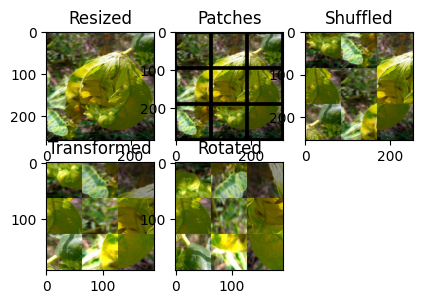

In [175]:
# Test

from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torchvision.transforms import transforms

# from google.colab import drive
# from matplotlib import pyplot as plt
# drive.mount('/content/drive/')

paths = ["/content/drive/MyDrive/COMP 6970 - Computer Vision/Final Project/extraimages_small/extra-image-100.jpg"]
# Define data transforms
data_transform = transforms.Compose([
    transforms.RandomCrop((64, 64)),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

dataset = JigsawPuzzleDatasetWithRotationWithPrints(paths, transform=data_transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for d in loader:
    print(d)
    break



# Defining Resnet model
Credit: https://github.com/aniket03/self_supervised_bird_classification

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, siamese_deg=9, train_contrastive=False):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.siamese_deg = siamese_deg
        self.train_contrastive = train_contrastive

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        if self.siamese_deg is None:
            self.fc = nn.Linear(2048 * block.expansion, num_classes)
        else:
            self.fc = nn.Linear(2048 * block.expansion * self.siamese_deg, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def get_feature_vectors(self, input_batch):
        # Each input_batch would be of shape (batch_size, color_channels, h, w)
        x = self.conv1(input_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    def forward(self, input_patch):

        return self.get_feature_vectors(input_patch)

        # Data returned by data loaders is of the shape (batch_size, no_patches, h_patch, w_patch)
        # That's why named input to patches_batch

        # if self.siamese_deg is None:
        #     final_feat_vectors = self.get_feature_vectors(input_batch)
        #     x = F.dropout(final_feat_vectors)
        #     x = F.log_softmax(self.fc(x))
        # elif not self.train_contrastive:
        #     final_feat_vectors = None

        #     for patch_ind in range(self.siamese_deg):
        #         # Each patch_batch would be of shape (batch_size, color_channels, h_patch, w_patch)
        #         print(input_batch.shape)
        #         patch_batch = input_batch[:, patch_ind, :, :, :]
        #         patch_batch_features = self.get_feature_vectors(patch_batch)

        #         if patch_ind == 0:
        #             final_feat_vectors = patch_batch_features
        #         else:
        #             final_feat_vectors = torch.cat([final_feat_vectors, patch_batch_features], dim=1)
        #     x = F.dropout(final_feat_vectors)
        #     x = F.log_softmax(self.fc(x))
        # else:
        #     q_img_batch = input_batch[:, 0, :, :, :]
        #     p_img_batch = input_batch[:, 1, :, :, :]
        #     n_img_batch = input_batch[:, 2, :, :, :]

        #     q_img_batch_feats = self.get_feature_vectors(q_img_batch)
        #     p_img_batch_feats = self.get_feature_vectors(p_img_batch)
        #     n_img_batch_feats = self.get_feature_vectors(n_img_batch)

        #     pos_sq_dist = torch.norm(q_img_batch_feats - p_img_batch_feats, p=2, dim=1) ** 2
        #     neg_sq_dist = torch.norm(q_img_batch_feats - n_img_batch_feats, p=2, dim=1) ** 2

        #     x = pos_sq_dist - neg_sq_dist

        # return x



def _resnet(block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)

    return model


def resnet18(**kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return _resnet(BasicBlock, [2, 2, 2, 2], **kwargs)


In [7]:

# ------------------------
# Jigsaw + Rotation ResNet
# ------------------------
class JigsawResNetWithRotation(nn.Module):
    def __init__(self, block=BasicBlock, layers=[2,2,2,2], num_patches=9):
        super().__init__()
        self.num_patches = num_patches
        self.backbone = ResNet(block, layers)
        feat_dim = 512 * block.expansion * 2 * 2  # 2x2 avgpool flatten

        # Separate heads for position (9 classes) and rotation (4 classes)
        self.position_heads = nn.ModuleList([nn.Linear(feat_dim, num_patches) for _ in range(num_patches)])
        self.rotation_heads = nn.ModuleList([nn.Linear(feat_dim, 4) for _ in range(num_patches)])

    def forward(self, x):
        # x: (batch_size, num_patches, 3, H, W)
        pos_outputs = []
        rot_outputs = []

        # feat = self.backbone(x)
        # pos_outputs.append(self.position_heads[i](feat))
        # rot_outputs.append(self.rotation_heads[i](feat))

        for i in range(self.num_patches):
            patch = x[:, i, :, :, :]
            feat = self.backbone(patch)
            pos_outputs.append(self.position_heads[i](feat))
            rot_outputs.append(self.rotation_heads[i](feat))
        pos_tensor = torch.stack(pos_outputs, dim=1)  # (batch_size, num_patches, 9)
        rot_tensor = torch.stack(rot_outputs, dim=1)  # (batch_size, num_patches, 4)
        return pos_tensor, rot_tensor

# ------------------------
# Factory function
# ------------------------
def jigsaw_resnet18(num_patches=9):
    return JigsawResNetWithRotation(BasicBlock, [2,2,2,2], num_patches)

In [8]:
import torch
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_

from datetime import datetime


def get_count_correct_preds(network_output, target):

    output = network_output
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    pred.data = pred.data.view_as(target.data)
    correct = target.eq(pred).sum().item()

    return correct


class ModelTrainTest():

    def __init__(self, network, device, model_file_path, threshold=1e-4):
        super(ModelTrainTest, self).__init__()
        self.network = network
        self.device = device
        self.model_file_path = model_file_path
        self.threshold = threshold
        self.train_loss = 1e9
        self.val_loss = 1e9

    def train(self, optimizer, epoch, params_max_norm, train_data_loader, val_data_loader):
        self.network.train()
        train_loss = 0
        correct = 0
        cnt_batches = 0

        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = Variable(data).to(self.device), Variable(target).to(self.device)

            optimizer.zero_grad()
            output = self.network(data)

            loss = F.nll_loss(output, target)
            loss.backward()

            clip_grad_norm_(self.network.parameters(), params_max_norm)
            optimizer.step()

            correct += get_count_correct_preds(output, target)
            train_loss += loss.item()
            cnt_batches += 1

            del data, target, output

        train_loss /= cnt_batches
        val_loss, val_acc = self.test(epoch, val_data_loader)

        if val_loss < self.val_loss - self.threshold:
            self.val_loss = val_loss
            torch.save(self.network.state_dict(), self.model_file_path)

        train_acc = correct / len(train_data_loader.dataset)

        print('\nAfter epoch {} - Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, train_loss, correct, len(train_data_loader.dataset),
            100. * correct / len(train_data_loader.dataset)))

        return train_loss, train_acc, val_loss, val_acc

    def test(self, epoch, test_data_loader):
        self.network.eval()
        test_loss = 0
        correct = 0

        for batch_idx, (data, target) in enumerate(test_data_loader):
            data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
            output = self.network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss

            correct += get_count_correct_preds(output, target)

            del data, target, output

        test_loss /= len(test_data_loader.dataset)
        test_acc = correct / len(test_data_loader.dataset)
        print('\nAfter epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, test_loss, correct, len(test_data_loader.dataset),
            100. * correct / len(test_data_loader.dataset)))

        return  test_loss, test_acc


class JigsawModelTrainTest():

    def __init__(self, network, device, model_file_path, threshold=1e-4):
        super(JigsawModelTrainTest, self).__init__()
        self.network = network
        self.device = device
        self.model_file_path = model_file_path
        self.threshold = threshold
        self.train_loss = 1e9
        self.val_loss = 1e9

    def train(self, optimizer, epoch, params_max_norm, train_data_loader, val_data_loader):
        self.network.train()
        train_loss = 0
        correct = 0
        cnt_batches = 0
        total_loss = 0
        total_correct_pos = 0
        total_correct_rot = 0
        total_patches = 0


        for batch_idx, (patches, perm, rot) in enumerate(train_data_loader):
            patches, perm, rot = Variable(patches).to(self.device), Variable(perm).to(self.device), Variable(rot).to(self.device)
            optimizer.zero_grad()
            pos_out, rot_out = self.network(patches)

            # Compute patch-wise cross entropy loss
            # loss_pos = sum(F.cross_entropy(pos_out[:, i, :], perm[:, i]) for i in range(9)) / 9
            # loss_rot = sum(F.cross_entropy(rot_out[:, i, :], rot[:, i]) for i in range(9)) / 9

            B, P, _ = pos_out.shape
            pos_out_flat = pos_out.reshape(B*P, P)
            perm_flat = perm.reshape(B*P)
            rot_out_flat = rot_out.reshape(B*P, 4)
            rot_flat = rot.reshape(B*P)
            loss_pos = F.cross_entropy(pos_out_flat, perm_flat)
            loss_rot = F.cross_entropy(rot_out_flat, rot_flat)
            loss = loss_pos + loss_rot

            loss.backward()
            clip_grad_norm_(self.network.parameters(), params_max_norm)
            optimizer.step()

            total_loss += loss.item() * patches.size(0)

            # Accuracy metrics
            pred_pos = pos_out.argmax(dim=2)
            pred_rot = rot_out.argmax(dim=2)
            total_correct_pos += (pred_pos == perm).sum().item()
            total_correct_rot += (pred_rot == rot).sum().item()
            total_patches += patches.size(0) * 9


            # loss = F.nll_loss(output, target)
            # loss.backward()

            # optimizer.step()

            # correct += get_count_correct_preds(output, target)

            train_loss += loss.item()

            cnt_batches += 1
            del patches, perm, rot, pos_out, rot_out



        # Half point for each correct position and each correct rotation
        correct = (total_correct_pos + total_correct_rot) / 2

        train_loss /= cnt_batches
        val_loss, val_acc = self.test(epoch, val_data_loader)

        if val_loss < self.val_loss - self.threshold:
            self.val_loss = val_loss
            torch.save(self.network.state_dict(), self.model_file_path)

        train_acc = correct / total_patches

        print('\nAfter epoch {} - Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Position accuracy: {}/{} ({:.0f}%), Rotation: {}/{}({:.0f}%)\n'.format(
            epoch, train_loss, correct, total_patches,
            100. * train_acc, total_correct_pos, total_patches, 100*total_correct_pos/total_patches, total_correct_rot, total_patches, 100*total_correct_rot/total_patches))



        return train_loss, train_acc, val_loss, val_acc

    def test(self, epoch, test_data_loader):
        self.network.eval()
        test_loss = 0
        correct = 0
        total_loss = 0
        total_correct_pos = 0
        total_correct_rot = 0
        total_patches = 0

        for batch_idx, (patches, perm, rot) in enumerate(test_data_loader):

            patches, perm, rot = Variable(patches).to(self.device), Variable(perm).to(self.device), Variable(rot).to(self.device)
            pos_out, rot_out = self.network(patches)

            # Compute patch-wise cross entropy loss
            # loss_pos = sum(F.cross_entropy(pos_out[:, i, :], perm[:, i]) for i in range(9)) / 9
            # loss_rot = sum(F.cross_entropy(rot_out[:, i, :], rot[:, i]) for i in range(9)) / 9
            # test_loss = loss_pos.item() + loss_rot.item()
            B, P, _ = pos_out.shape
            pos_out_flat = pos_out.reshape(B*P, P)
            perm_flat = perm.reshape(B*P)
            loss_pos = F.cross_entropy(pos_out_flat, perm_flat).item()
            rot_out_flat = rot_out.reshape(B*P, 4)
            rot_flat = rot.reshape(B*P)
            loss_rot = F.cross_entropy(rot_out_flat, rot_flat).item()
            test_loss = (loss_pos + loss_rot)

            # data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
            # output = self.network(data)
            # test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss


            # Accuracy metrics
            pred_pos = pos_out.argmax(dim=2)
            pred_rot = rot_out.argmax(dim=2)
            total_correct_pos += (pred_pos == perm).sum().item()
            total_correct_rot += (pred_rot == rot).sum().item()
            total_patches += patches.size(0) * 9

            # Half point for each correct position and each correct rotation
            correct += (total_correct_pos + total_correct_rot) / 2
            # correct += get_count_correct_preds(output, target)

            del patches, perm, rot, pos_out, rot_out

        test_loss /= len(test_data_loader.dataset)
        test_acc = correct / total_patches
        print('\nAfter epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Position accuracy: {}/{} ({:.0f}%), Rotation: {}/{}({:.0f}%)\n'.format(
            epoch, test_loss, correct, total_patches,
            100. * test_acc, total_correct_pos, total_patches, 100*total_correct_pos/total_patches, total_correct_rot, total_patches, 100*total_correct_rot/total_patches))

        return  test_loss, test_acc


# Jigsaw as pretext task training

In [19]:
#for jigsaw ssl task
import argparse
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torchvision.transforms import transforms
from matplotlib import pyplot as plt


if __name__ == '__main__':

    Cexperiment_name = 'e1_js'
    Cdataset_config = 'js_d2'
    Cweight_decay = 1e-10 #5e-4
    Clr = 1e-4 # originally 1e-2
    Cepochs = 30
    Cbatch_size = 2
    data_dir = "extraimages"
    num_patches = 9

    # Data files which will get referred
    permuts_file_path = 'selected_permuts.npy'

    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #par_weights_dir = 'weights/'
    model_file_path = 'resnet_jigsaw_solver_{}_trained.pt'.format(Cexperiment_name)

    all_file_paths = get_paths(data_dir)

    # Get validation files separate
    train_file_paths, val_file_paths = train_test_split(all_file_paths, test_size=0.1, shuffle=True, random_state=3)

    # Compute channel means
    channel_means = np.array([124.09, 127.67, 110.50]) / 256.0

    # Define data transforms
    data_transform = transforms.Compose([
        # transforms.RandomCrop((64, 64)),
        transforms.ColorJitter(brightness=[0.5, 1.5]),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    # Define data loaders
    batch_size = Cbatch_size


    if Cdataset_config == 'js_d1':
        train_data_loader = DataLoader(
            ConcatDataset(
                [JigsawPuzzleDatasetWithRotation(train_file_paths,
                                        range_permut_indices=[st_perm_ind, st_perm_ind+9], transform=data_transform)
                 for st_perm_ind in range(0, 100, 10)
                ]
            ),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
        val_data_loader = DataLoader(
            ConcatDataset(
                [JigsawPuzzleDatasetWithRotation(val_file_paths,
                                        range_permut_indices=[st_perm_ind, st_perm_ind + 9], transform=data_transform)
                 for st_perm_ind in range(0, 100, 10)
                 ]
            ),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
    else:
        train_data_loader = DataLoader(
            JigsawPuzzleDatasetWithRotation(train_file_paths, transform=data_transform),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
        val_data_loader = DataLoader(
            JigsawPuzzleDatasetWithRotation(val_file_paths, transform=data_transform),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
    print("Loaders done")
    # Print sample batches that would be returned by the train_data_loader
    # dataiter = iter(train_data_loader)
    # X,  perm_tensor, rot_tensor = dataiter.__next__()
    # print (X.size())
    # print (perm_tensor.size())
    # print (rot_tensor.size())

    # Train required model defined above on CUB200 data
    num_outputs = 100#200
    epochs = Cepochs
    lr = Clr
    weight_decay_const = Cweight_decay

    # If using Resnet18
    model_to_train = jigsaw_resnet18(num_patches=num_patches)
    print('Model ready')
    # Set device on which training is done. Plus optimizer to use.
    model_to_train.to(device)
    optimizer = optim.SGD(model_to_train.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_const)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, min_lr=1e-5)

    # Start training
    print('Started training')
    model_train_test_obj = JigsawModelTrainTest(model_to_train, device, model_file_path)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch_no in range(epochs):
        print("Epoch no {} #######################".format(epoch_no))
        train_loss, train_acc, val_loss, val_acc = model_train_test_obj.train(
            optimizer, epoch_no, params_max_norm=4,
            train_data_loader = train_data_loader, val_data_loader = val_data_loader
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print("Train loss {} \n Val loss {} \n Train Acc {} \n Val Acc {}".format(train_loss,val_loss,train_acc,val_acc))
        scheduler.step(val_loss)

    observations_df = pd.DataFrame()
    observations_df['epoch count'] = [i for i in range(1, Cepochs + 1)]
    observations_df['train loss'] = train_losses
    observations_df['val loss'] = val_losses
    observations_df['train acc'] = train_accs
    observations_df['val acc'] = val_accs
    observations_file_path = Cexperiment_name + '_observations.csv'
    observations_df.to_csv(observations_file_path)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaders done
Model ready
Started training
Epoch no 0 #######################

After epoch 0 - Test set: Average loss: 3.8581, Accuracy: 0.5/9 (6%), Position accuracy: 0/9 (0%), Rotation: 1/9(11%)


After epoch 0 - Train set: Average loss: 4.0125, Accuracy: 3.0/27 (11%), Position accuracy: 2/27 (7%), Rotation: 4/27(15%)

Train loss 4.012451171875 
 Val loss 3.858125329017639 
 Train Acc 0.1111111111111111 
 Val Acc 0.05555555555555555
Epoch no 1 #######################

After epoch 1 - Test set: Average loss: 3.9830, Accuracy: 0.0/9 (0%), Position accuracy: 0/9 (0%), Rotation: 0/9(0%)


After epoch 1 - Train set: Average loss: 3.9796, Accuracy: 4.5/27 (17%), Position accuracy: 5/27 (19%), Rotation: 4/27(15%)

Train loss 3.9795855283737183 
 Val loss 3.9829626083374023 
 Train Acc 0.16666666666666666 
 Val Acc 0.0
Epoch no 2 #######################

After epoch 2 - Test set: Average loss: 3.9947, Accuracy: 1.0/9 (11%), Position accuracy: 1/9 (11%), Rotation: 1/9(11%)


After epoch 2 - Tr

# Plot loss and accuracy curves

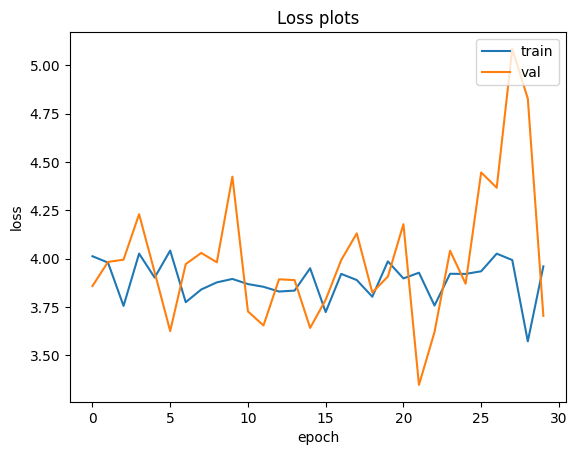

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss plots')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('loss.jpg')

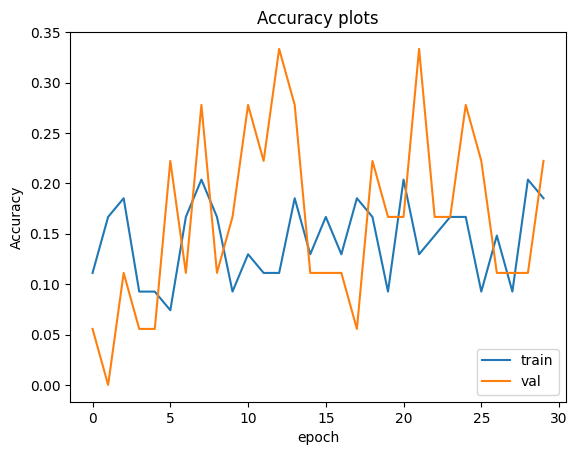

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Accuracy plots')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.show()
plt.savefig('accuracy.jpg')

In [ ]:
model = jigsaw_resnet18(num_patches=9)
model.load_state_dict(torch.load('resnet_jigsaw_solver_e1_js_trained.pt'))
model.eval()

